In [1]:
%pip install openai==0.28.0 
%pip install s3fs
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

df = pd.read_csv('titles_falses_final.csv')

df.head()



,JOB_TITLE
0,wxf bzr
1,mkq szn
2,vop rpfq
3,ypl-3qf
4,tspx vq


In [2]:
df.shape

(10904, 1)

# Processing Embeddings in Batches

This Jupyter notebook details the process for batch processing embeddings using OpenAI's API and managing state and output via Amazon S3.


## Configuration and Constants

- API key for OpenAI.
- `batch_size`: Size of each batch of texts to process.
- `EMBEDDING_DIM`: The dimension of each embedding vector.
- `ZERO_EMBEDDING`: A zero vector for embeddings as a placeholder.

## Functions

### create_embeddings_batch
This function takes a list of texts and attempts to retrieve embeddings from the OpenAI API. It handles retries and failures by providing zero vectors as placeholders.

#### Parameters
- `texts`: A list of strings for which embeddings are to be generated.
- `max_retries`: Maximum number of retries for OpenAI API calls.

#### Returns
A list of embeddings, either retrieved or zero-filled based on API call success.

## Main Process

1. Initialize S3 filesystem.
2. Check for the last processed batch in a checkpoint file on S3.
3. Calculate total batches needed based on data size.
4. Loop through each batch, process it, and store results:
    - Skip already processed batches.
    - Process each batch by extracting text, fetching embeddings, and storing them back in the DataFrame.
    - Save the DataFrame with embeddings to an S3 path.
    - Update the checkpoint file after each batch is processed.

### Output
Prints completion of processing upon finishing all batches.


In [8]:
import openai
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import json
import s3fs
import os


openai.api_key = ""

batch_size = 100
EMBEDDING_DIM = 1536
ZERO_EMBEDDING = [0.0] * EMBEDDING_DIM

def create_embeddings_batch(texts, max_retries=3):
    embeddings = []
    non_empty_indices = [i for i, text in enumerate(texts) if isinstance(text, str) and text.strip()]
    non_empty_texts = [text for text in texts if isinstance(text, str) and text.strip()]
    for attempt in range(max_retries):
        try:
            if non_empty_texts:
                response = openai.Embedding.create(
                    input=non_empty_texts,
                    model="text-embedding-ada-002"
                )
                batch_embeddings = [item['embedding'] for item in response['data']]
                if len(batch_embeddings) != len(non_empty_texts):
                    batch_embeddings = [ZERO_EMBEDDING] * len(non_empty_texts)
                break
        except Exception as e:
            print(f"Error en el intento {attempt + 1}: {e}")
            time.sleep(2)
    else:
        batch_embeddings = [ZERO_EMBEDDING] * len(non_empty_texts)

    full_embeddings = [ZERO_EMBEDDING] * len(texts)
    for idx, emb in zip(non_empty_indices, batch_embeddings):
        if len(emb) == EMBEDDING_DIM:
            full_embeddings[idx] = emb
        else:
            full_embeddings[idx] = ZERO_EMBEDDING
    return full_embeddings

fs = s3fs.S3FileSystem()

checkpoint_file = 's3://ml-translation-input-dev/checkpointfalses.json'
output_s3_dir = 's3://ml-translation-input-dev/output/'

if 'embedding' not in df.columns:
    df['embedding'] = None

if fs.exists(checkpoint_file):
    with fs.open(checkpoint_file, 'r') as f_chk:
        processed_batches = json.load(f_chk)
else:
    processed_batches = []

total_batches = len(df) // batch_size + 1

for i in tqdm(range(0, len(df), batch_size), desc="Procesando Batches"):
    if i in processed_batches:
        continue  

    batch_df = df.iloc[i:i + batch_size]
    batch_texts = batch_df['JOB_TITLE'].astype(str).tolist()  
    batch_embeddings = create_embeddings_batch(batch_texts)

    batch_df['embedding'] = [json.dumps(emb) for emb in batch_embeddings]

    batch_number = i // batch_size
    batch_output_path = os.path.join(output_s3_dir, f'embeddings_batch_falses{batch_number}.csv')
    with fs.open(batch_output_path, 'w') as f_out:
        batch_df[['JOB_TITLE', 'embedding']].to_csv(f_out, index=False)

    processed_batches.append(i)
    with fs.open(checkpoint_file, 'w') as f_chk:
        json.dump(processed_batches, f_chk)

    time.sleep(1)

print("Processing of embeddings completed.")

Procesando Batches:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipykernel_6285/2752071331.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['embedding'] = [json.dumps(emb) for emb in batch_embeddings]
Procesando Batches:   1%|          | 1/110 [00:02<04:09,  2.29s/it]/tmp/ipykernel_6285/2752071331.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['embedding'] = [json.dumps(emb) for emb in batch_embeddings]
Procesando Batches:   2%|▏         | 2/110 [00:04<04:11,  2.33s/it]/tmp/ipyker

Processing of embeddings completed.


# Unifying Batches into a Single CSV File

This notebook describes the process of combining multiple CSV files containing embeddings into a single CSV file, and uploading it to an S3 bucket.

## Configuration and Paths

- S3 directory for output batches.
- Final output path on S3 for the combined CSV.
- Local path for the combined file creation.

## Functions

### verificar_embedding
Checks if the string representation of an embedding is correct.

#### Parameters
- `embedding_str`: JSON string of the embedding.
- `dim`: Expected dimension of the embedding vector.

#### Returns
Boolean value indicating if the embedding is correctly formed.

## Main Process

1. Initialize S3 filesystem.
2. List CSV files in the specified output directory on S3.
3. Open a local file to write the combined CSV.
4. For each batch file:
    - Read the batch into a DataFrame.
    - Validate embeddings using the `verificar_embedding` function.
    - Record and print the number of incorrect embeddings.
    - Write valid batch data into the final CSV, managing headers appropriately.
5. Upload the final combined CSV to the specified S3 path.

### Output
Prints the number of incorrect embeddings for each batch and confirms the saving of the final file on S3.


In [9]:


fs = s3fs.S3FileSystem()

output_s3_dir = 's3://ml-translation-input-dev/output/'  
final_output_s3_path = 's3://ml-translation-input-dev/job_titles_with_embeddings_falses.csv'

local_final_path = '/tmp/job_titles_with_embeddings_falses.csv'

def verificar_embedding(embedding_str, dim=1536):
    try:
        embedding = json.loads(embedding_str)
        return isinstance(embedding, list) and len(embedding) == dim
    except:
        return False

batch_files = fs.ls(output_s3_dir)


header_written = False

with open(local_final_path, 'w', encoding='utf-8') as f_final:
    for file in tqdm(batch_files, desc="Unificando Batches"):
        if file.endswith('.csv'):
            with fs.open(file, 'r') as f_batch:
                df_batch = pd.read_csv(f_batch)
            
            df_batch['valid_embedding'] = df_batch['embedding'].apply(verificar_embedding)
            
            if not df_batch['valid_embedding'].all():
                num_incorrectos = (~df_batch['valid_embedding']).sum()
                print(f"El batch {file} tiene {num_incorrectos} embeddings incorrectos.")
            
            df_batch.drop(columns=['valid_embedding'], inplace=True)
            
            # Escribir en el archivo final
            df_batch.to_csv(
                f_final, 
                index=False, 
                header=not header_written, 
                mode='w' if not header_written else 'a', 
                encoding='utf-8'
            )
            
            if not header_written:
                header_written = True

with open(local_final_path, 'rb') as f_final:
    fs.put(local_final_path, final_output_s3_path)

print("Archivo final combinado y guardado en S3.")


Unificando Batches: 100%|██████████| 111/111 [00:46<00:00,  2.38it/s]


Archivo final combinado y guardado en S3.


# Validation of Embeddings in S3 CSV File

This notebook outlines the procedure for validating the embeddings stored in a CSV file on Amazon S3. The validation checks if each embedding has the correct format and dimension.

## Constants

- `chunksize`: Number of rows to process at a time to manage memory usage efficiently.

## Functions

### verificar_embedding
Verifies the integrity of an embedding parsed from a JSON string.

#### Parameters
- `embedding_str`: The JSON string representing an embedding.
- `dim`: The expected dimensionality of the embedding vector.

#### Returns
A boolean indicating whether the embedding is correctly formatted and matches the expected dimension.

## Main Validation Process

1. Initialize S3 filesystem.
2. Initialize counters for total, correct, and incorrect embeddings.
3. Process the CSV file in chunks to validate each embedding:
   - Apply the `verificar_embedding` function to check each embedding.
   - Update counters based on validation results.
4. Print summary statistics:
   - Total number of embeddings processed.
   - Number of correct embeddings.
   - Number of incorrect embeddings.

### Output
Displays counts of total, correct, and incorrect embeddings after processing the entire file, providing insight into the data's integrity.


In [10]:
import pandas as pd
import s3fs
import json

fs = s3fs.S3FileSystem()

final_output_s3_path = 's3://ml-translation-input-dev/job_titles_with_embeddings_falses.csv'

chunksize = 10000 

def verificar_embedding(embedding_str, dim=1536):
    try:
        embedding = json.loads(embedding_str)
        return isinstance(embedding, list) and len(embedding) == dim
    except:
        return False

total_embeddings = 0
correct_embeddings = 0
incorrect_embeddings = 0

for chunk in pd.read_csv(fs.open(final_output_s3_path, 'r'), chunksize=chunksize):
    chunk['valid_embedding'] = chunk['embedding'].apply(verificar_embedding)
    correct = chunk['valid_embedding'].sum()
    incorrect = (~chunk['valid_embedding']).sum()
    total_embeddings += len(chunk)
    correct_embeddings += correct
    incorrect_embeddings += incorrect

print(f"Total embeddings processed: {total_embeddings}")
print(f"Embeddings corrects: {correct_embeddings}")
print(f"Embeddings incorrects: {incorrect_embeddings}")


Total embeddings processed: 10904
Embeddings corrects: 10904
Embeddings incorrects: 0


# Training with XGBoost

# Data Preparation for Model Training

This notebook segment focuses on preparing data for model training, including parsing embeddings, encoding labels, and splitting the dataset.

## Libraries and Imports

- `sklearn.model_selection`: For splitting the dataset into training and testing sets.
- `sklearn.preprocessing`: For encoding labels.
- `joblib`: For saving the label encoder.
- `numpy`: Used for handling arrays.

## Processing Steps

1. **Parse Embeddings**: Convert embedding strings to lists; replace errors with zero vectors.
2. **Filter Data**: Ensure all embeddings have the correct dimension.
3. **Prepare Features and Labels**:
   - Convert embeddings list to a NumPy array for model input.
   - Encode labels using `LabelEncoder`.
4. **Calculate Class Weights**: Used for balancing the classes in training.
5. **Split Dataset**: Divide data into training and testing sets with a stratified split.
6. **Save Data and Encoder**: Output arrays and encoder to files for later use.

## Output

Confirms that data preparation is complete and all necessary files are saved.


In [ ]:
df_reals = pd.read_csv('Garbage_Collector/Data/titles_real_final.csv')
df_falses = pd.read_csv('Garbage_Collector/Data/job_titles_with_embeddings_falses.csv')

In [56]:
print(df_reals.shape)
df_falses.shape

(10853, 10)


(10904, 2)

In [57]:
df_reals = df_reals[['JOB_TITLE', 'embedding']]

In [58]:
df_reals['label'] = True
df_falses['label'] = False

In [59]:
df_falses.head()

,JOB_TITLE,embedding,label
0,wxf bzr,"[-0.024321123957633972, 0.005969209596514702, ...",False
1,mkq szn,"[-0.012344743125140667, -0.004032758995890617,...",False
2,vop rpfq,"[-0.005112423095852137, -0.0014533227076753974...",False
3,ypl-3qf,"[-0.026576558127999306, -0.015471403487026691,...",False
4,tspx vq,"[-0.009216103702783585, 0.014240390621125698, ...",False


In [60]:
df_train = pd.concat([df_reals,df_falses], ignore_index = True)

In [61]:
df_train.shape

(21757, 3)

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib


EMBEDDING_DIM = 1536

def parse_embedding(embedding_str):
    try:
        return json.loads(embedding_str)
    except:
        return [0.0] * EMBEDDING_DIM

df_train['embedding'] = df_train['embedding'].apply(parse_embedding)
df_train = df_train[df_train['embedding'].apply(len) == EMBEDDING_DIM]

X = np.array(df_train['embedding'].tolist())
y = df_train['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_series = pd.Series(y_encoded)
class_counts = y_series.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Data preparation complete. Data saved for model training.")



In [ ]:


EMBEDDING_DIM = 1536

def parse_embedding(embedding_str):
    try:
        return json.loads(embedding_str)
    except:
        return [0.0] * EMBEDDING_DIM

if 'JOB_TITLE' not in df_train.columns:
    raise ValueError("The 'JOB_TITLE' column is missing from df_train.")

df_train['embedding'] = df_train['embedding'].apply(parse_embedding)

df_train = df_train[df_train['embedding'].apply(len) == EMBEDDING_DIM]

X = np.array(df_train['embedding'].tolist())
y = df_train['label']

job_titles = df_train['JOB_TITLE'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_series = pd.Series(y_encoded)
class_counts = y_series.value_counts()
if len(class_counts) >= 2:
    scale_pos_weight = class_counts[0] / class_counts[1]
    print(f"Scale_pos_weight calculated: {scale_pos_weight}")
else:
    scale_pos_weight = 1.0
    print("Not enough classes to calculate scale_pos_weight. Defaulting to 1.0.")

X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(
    X,
    y_encoded,
    job_titles,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded
)

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('job_train.npy', job_train)
np.save('job_test.npy', job_test)

joblib.dump(label_encoder, 'label_encoder.pkl')

print("Data preparation complete. Data and JOB_TITLEs saved for model training.")


# Model Training with Grid Search

This notebook segment sets up a grid search for hyperparameter tuning of an XGBoost classifier.

## Setup and Libraries

- `xgboost` and `numpy` for modeling.
- `GridSearchCV` from sklearn for optimization.
- `f1_score` for evaluation.

## Model Configuration

- Initializes an XGBoost classifier with predefined objectives and evaluation metrics.
- Defines a parameter grid focusing on key hyperparameters such as `n_estimators`, `max_depth`, etc.

## Grid Search Execution

- Configures `GridSearchCV` with the classifier, parameter grid, and scoring function.
- Fits the model on the training data to find the best hyperparameters.

## Output

Displays the best hyperparameters after the grid search.


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'   
)

param_grid = {
    'n_estimators': [150],
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

f1 = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=f1,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Model Training and Evaluation

This section demonstrates training an XGBoost classifier and evaluating its performance on a test set.

## Setup

- Utilizes `xgboost`, `numpy`, and `pickle` for training and serialization.
- Loads training and testing datasets from `.npy` files.

## Training

- Configures and trains an XGBoost classifier with specific parameters such as `max_depth`, `learning_rate`, and others crucial for performance tuning.

## Prediction and Evaluation

- Makes predictions on the test set.
- Computes performance metrics: accuracy, precision, recall, and F1 score.

## Model Serialization

- Serializes the trained model to a `.pkl` file for future use.

## Output

- Prints performance metrics and confirms model serialization.


In [90]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle  

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')  
y_test = np.load('y_test.npy')

best_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=150,
    subsample=0.8
)

best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Guardar el modelo entrenado en un archivo .pkl
with open('best_clf.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

print("Modelo guardado exitosamente en 'best_clf.pkl'")



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9653033088235294
Precision: 0.9658671586715867
Recall: 0.9645324735145094
F1 Score: 0.9651993546900207
Modelo guardado exitosamente en 'best_clf.pkl'


# Model Evaluation and Error Analysis

This section covers the visualization of the confusion matrix, identification of misclassified instances, and recommendations for model improvement based on the results.

## Performance Metrics and Confusion Matrix

- The model achieves high accuracy, precision, recall, and F1 scores, indicating strong performance.
- A confusion matrix is displayed using Seaborn to visualize true vs. predicted labels.

## Error Analysis

- The `errors_df` DataFrame is created to investigate specific instances where predictions were incorrect, including job titles and feature values.
- Errors are analyzed, suggesting that some misclassifications might be due to incorrect labels rather than model performance.


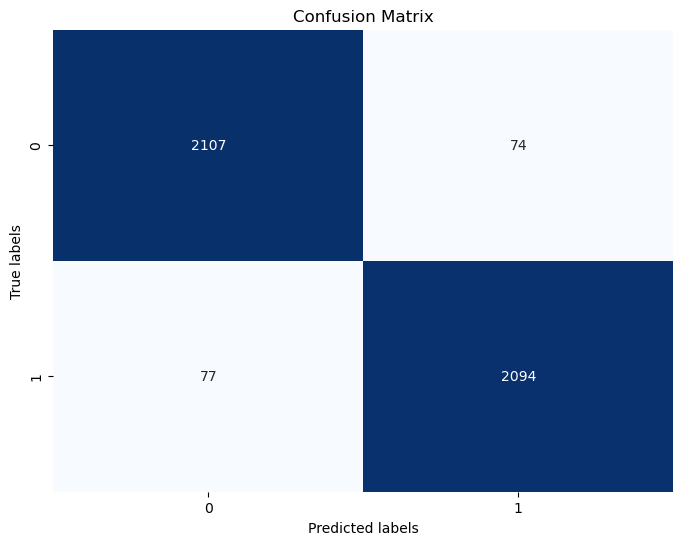

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
job_test = np.load('job_test.npy', allow_pickle=True)

indices_incorrect = np.where(y_pred != y_test)[0]

errors_df = pd.DataFrame({
    'Index': indices_incorrect,
    'Features': [X_test.iloc[index] if isinstance(X_test, pd.DataFrame) else X_test[index] for index in indices_incorrect],
    'Actual Value': y_test[indices_incorrect],
    'Incorrect Prediction': y_pred[indices_incorrect],
    'JOB_TITLE': [job_test[index] for index in indices_incorrect]
})

errors_df.head()


,Index,Features,Actual Value,Incorrect Prediction,JOB_TITLE
0,8,"[-0.006577917840331793, -0.027783839032053947,...",0,1,klatretårsarkitekt
1,31,"[-0.005794755183160305, 0.002430111635476351, ...",1,0,elektromechanik dwie zmiany solidne warunki
2,76,"[-0.010070865042507648, -0.005881949793547392,...",1,0,pemasar
3,84,"[-0.02479843981564045, -0.01266831811517477, 0...",0,1,ih tvc
4,109,"[-0.00799555703997612, -0.01101016253232956, -...",1,0,responsable études de prix


In [89]:
for i in range(len(errors_df[errors_df['Incorrect Prediction'] == 1])):
    print(errors_df['JOB_TITLE'][errors_df['Incorrect Prediction'] == 1].iloc[i])
    


klatretårsarkitekt
ih tvc
atleta de controle remoto
skovsneglenes chef
Servicios Comunitarios Ltda
fabricante de barcos de papel
yöpöydän hoitaja
taskunpuhdistaja
gatstenstränare
Lachmuskeltrainer im Büro
såpbubblåstekniker
bygg karriere innen salg
vannglasskurator på sommerferie
hviledagsarrangør hverdag
rosvopäällikkö
recolector de gotes
学生向け特別職
自由報酬顧問募集
fjärrkontrollsviftare
シフト自由勤務
costruttore di magia
vendeur de néants
晨露收集师
lommebokvokter på byen
seinäkellonsoittaja
lysesmed
tessitore di storie
légykapó specialista
asesor en fiestas locas
kierownik frytek
银河栽培员
konsultin tehtävä vapaavalintainen
löhöilyn asiantuntija
døgnets festplanlægger
łowca grilla
ledig rolle i ledende firma
wsparcie finansowe i szkolenia dla nowych pracowników
vedlejší systémy provize pracovní
советовать
työpaikka korkeakouluopiskelijoille suunnattu
nova carrera professional
locutor de olas de mar
vendedor de bolhas
putetrikser med sertifisering
manažer příjem sociální příležitost
zahradník vzdušných zámků



## Conclusion

- The model's high performance suggests it is well-tuned to the dataset, but there is room for improvement, particularly in handling potential label inaccuracies.

## Proposals for Improvement

1. **Improve Labeling Model**: Enhancing the accuracy of the labeling process could reduce errors and improve model performance.
2. **Upgrade Embeddings**: Using more advanced embeddings from OpenAI could yield better feature representations and improve classification results.
3. **Hyperparameter Optimization**: A more extensive grid search for XGBoost could be beneficial, especially if computational resources allow.
4. **Minimize False Negatives**: Adjusting the class weight might help reduce false negatives, balancing optimization against efficiency and cost.

These improvements could help address underlying issues in the data and model configuration, potentially leading to even better performance.
